### GAN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import Activation, Dense, Conv2D, Flatten, MaxPool2D, AveragePooling2D, Dropout, Reshape
from tensorflow.keras.losses import categorical_crossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import tensorflow_datasets as tfds

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Загрузим датасет LFW
train, info = tfds.load(
    'lfw',
    split=['train'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [4]:
train = train[0]

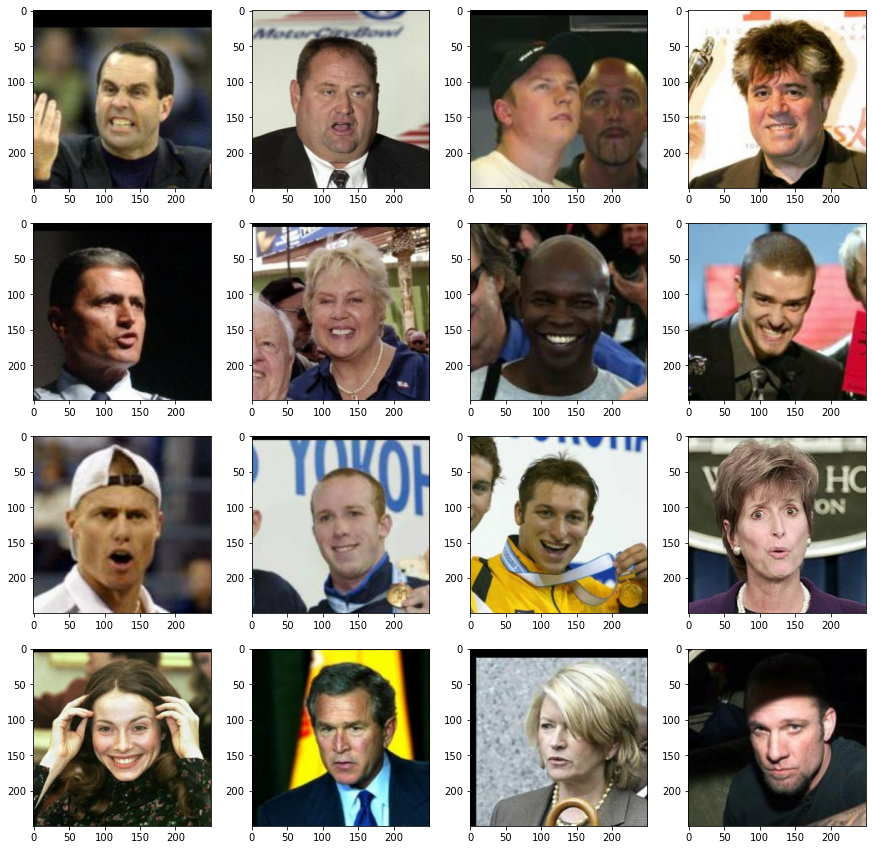

In [5]:
# Проверим, что там
plt.figure(figsize=(15, 15))
for i, (_, image) in enumerate(train.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image.numpy().astype("uint8"))

In [6]:
# В некоторых фотках по два лица сразу.. в целом это дополнительная трудность для сети ))

In [7]:
# Готовим и разбиваем на батчи и эпохи датасет
def normalize_img(_, image):
    return (tf.cast(image, tf.float32) - 127.5) / 127.5

In [8]:
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.0002

In [9]:
# Разбиваем на батчи, делаем эпохи, готовим к фиту вобщем...
train_ds = train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.repeat(EPOCHS)
train_ds = train_ds.shuffle(len(train))
train_ds = train_ds.batch(int(BATCH_SIZE/2), drop_remainder=True)
train_ds = train_ds.cache()
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
# Сама сеть
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*8*8, activation='relu'),
    tf.keras.layers.Reshape((8, 8, 256)),
    
    tf.keras.layers.UpSampling2D((2, 2)),    # 16x16
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),
    
    tf.keras.layers.UpSampling2D((2, 2)),    # 32x32
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),
    
    tf.keras.layers.UpSampling2D((2, 2)),    # 64x64
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),
    
    tf.keras.layers.UpSampling2D((2, 2)),    # 128x128
    tf.keras.layers.Conv2D(32, (3, 3)),     # 126x126
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),
    
    tf.keras.layers.UpSampling2D((2, 2)),    # 252x252
    tf.keras.layers.Conv2D(16, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),
    
    tf.keras.layers.Conv2D(3, (3, 3), activation='tanh'), # 250x250
])

In [12]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'), # 125x125
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'), # 63x63
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'), # 32x32
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'), # 16x16
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'), # 8x8
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same'), # 4x4
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
])

In [13]:
# Процесс тренировки

[step=0] Дискриминатор loss: 0.7862481474876404,               Генератор loss 0.2454344928264618


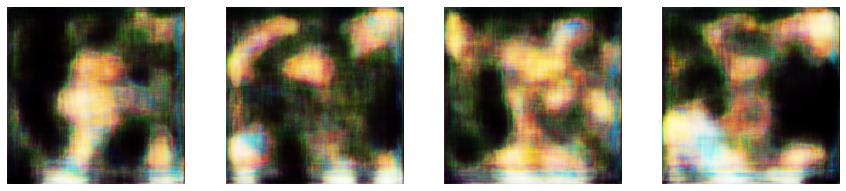

[step=400] Дискриминатор loss: 0.49317485094070435,               Генератор loss 0.9570856094360352


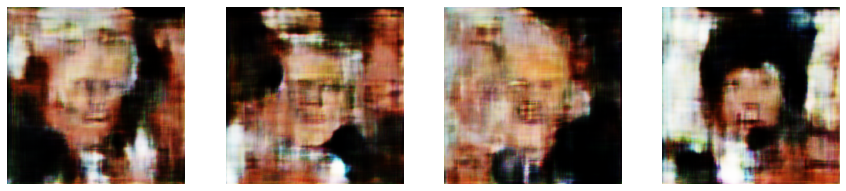

[step=800] Дискриминатор loss: 0.6665583252906799,               Генератор loss 1.0428003072738647


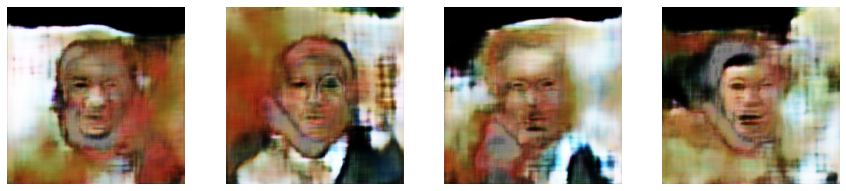

[step=1200] Дискриминатор loss: 0.3506978750228882,               Генератор loss 0.09170249104499817


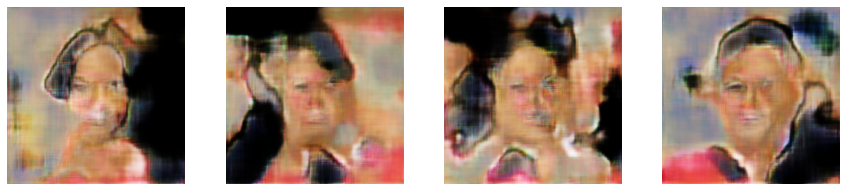

[step=1600] Дискриминатор loss: 0.25968727469444275,               Генератор loss 0.9127719402313232


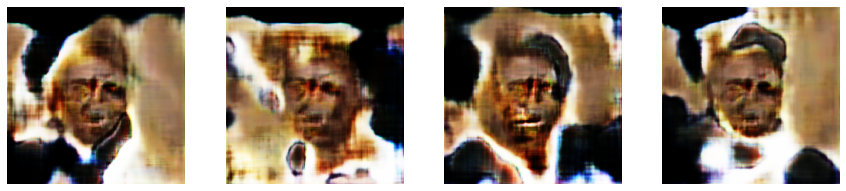

[step=2000] Дискриминатор loss: 0.3909696340560913,               Генератор loss 3.5486879348754883


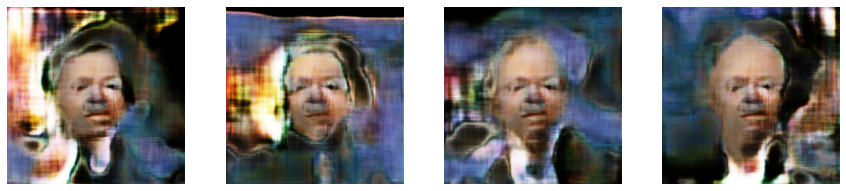

[step=2400] Дискриминатор loss: 0.18134278059005737,               Генератор loss 1.328662633895874


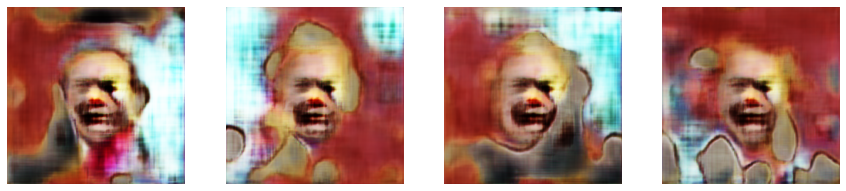

[step=2800] Дискриминатор loss: 0.1889391839504242,               Генератор loss 2.0664193630218506


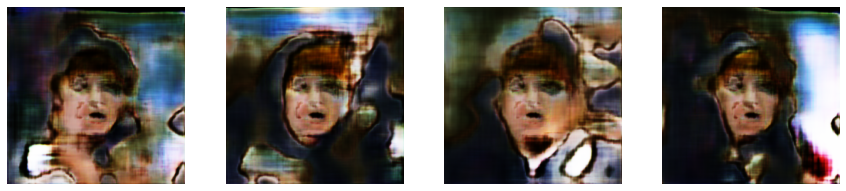

[step=3200] Дискриминатор loss: 0.5370829701423645,               Генератор loss 2.15346097946167


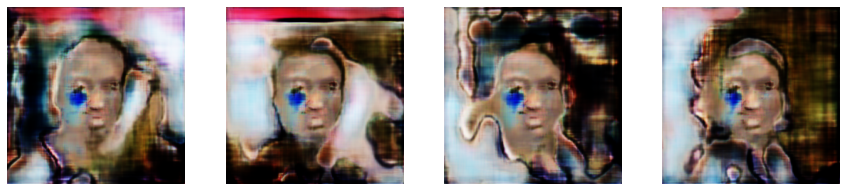

[step=3600] Дискриминатор loss: 0.13717131316661835,               Генератор loss 1.8464429378509521


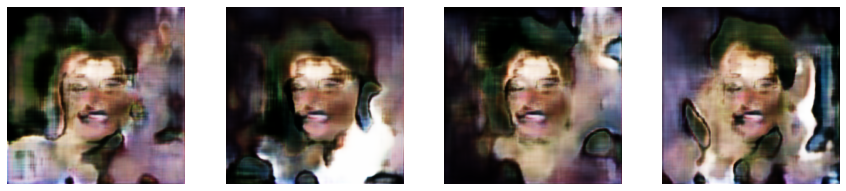

In [ ]:
for step, true_images in enumerate(train_ds):
    
    # Дискриминатор
    
    noise = np.random.normal(0, 1, (int(BATCH_SIZE/2), 100)).astype(np.float32)
    fake_images = generator.predict(noise)
    x_combined = np.concatenate((true_images, fake_images))
    y_combined = np.concatenate((np.ones((int(BATCH_SIZE/2), 1), np.float32),
                                np.zeros((int(BATCH_SIZE/2), 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined)
        d_loss_value = loss(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
        
    # Генератор
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, 100)).astype(np.float32)
    y_mislabeled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        logits = discriminator(generator(noise, training=True))
        g_loss_value = loss(y_mislabeled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    if step % 400 == 0:
        print(f'[{step=}] Дискриминатор loss: {d_loss_value.numpy()}, \
              Генератор loss {g_loss_value.numpy()}')
        noise = np.random.normal(0, 1, (4, 100)).astype(np.float32)
        fake_images = generator.predict(noise)
        
        plt.figure(figsize=(15, 15))
        for i, image in enumerate(fake_images):
            ax = plt.subplot(4, 4, i + 1)
            image = image / 2 + 0.5
            ax.imshow(image)
            plt.axis("off")
        plt.show()

In [ ]:
# В этом месте я достиг предела оперативки (64gb) почему-то когда учу через gradienttape 
# Память постепенно утекает... Как с этим бороться? И возможно ли? Или просто останавливать
# Процесс, сохранять веса, перезагружать ноутбук и начинать дальше с этого места?

# (Вопрос наставнику!)

In [ ]:
# По поводу полученного результата - ну наверное можно дотянуть до чего-то менее жуткого...))
# Пока-что выглядит как плод воображения тяжелобольного, разглядывающего обои на стене палаты ))

In [77]:
generator.save('saved_model/generator')
discriminator.save('saved_model/discriminator')

INFO:tensorflow:Assets written to: saved_model/generator/assets


INFO:tensorflow:Assets written to: saved_model/generator/assets


INFO:tensorflow:Assets written to: saved_model/discriminator/assets


INFO:tensorflow:Assets written to: saved_model/discriminator/assets


### Есть мысль по-другому подготовить данные..
Во-первых сделать фотки меньшего разрешения, чтобы сэкономить память и реже перезагружать процесс тренировки. Во-вторых - маппинг [-1: 1] это же не догма. Это было показано для MNIST - возможно тут лучше результат получится на [0: 1]?

In [5]:
def normalize_img(_, image):
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, (128, 128))
    return image

In [6]:
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.0002

In [7]:
# Разбиваем на батчи, делаем эпохи, готовим к фиту вобщем...
train_ds = train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.repeat(EPOCHS)
train_ds = train_ds.shuffle(len(train))
train_ds = train_ds.batch(int(BATCH_SIZE/2), drop_remainder=True)
train_ds = train_ds.cache()
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
# Сама сеть
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*32*32, activation='relu'),
    tf.keras.layers.Reshape((32, 32, 256)),
    
    # tf.keras.layers.UpSampling2D((2, 2)),    # 16x16
    # tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    # tf.keras.layers.BatchNormalization(momentum=0.8),
    # tf.keras.layers.ReLU(),
    
    # tf.keras.layers.UpSampling2D((2, 2)),    # 32x32
    # tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    # tf.keras.layers.BatchNormalization(momentum=0.8),
    # tf.keras.layers.ReLU(),
    
    tf.keras.layers.UpSampling2D((2, 2)),    # 64x64
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),
    
    tf.keras.layers.UpSampling2D((2, 2)),    # 128x128
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),
    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),
    
    # tf.keras.layers.UpSampling2D((2, 2)),    # 252x252
    # tf.keras.layers.Conv2D(16, (3, 3), padding='same'),
    # tf.keras.layers.BatchNormalization(momentum=0.8),
    # tf.keras.layers.ReLU(),
    
    tf.keras.layers.Conv2D(3, (3, 3), activation='tanh', padding='same'), # 128x128
])

In [9]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'), # 64x64
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'), # 32x32
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'), # 16x16
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'), # 8x8
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'), # 4x4
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    
    # tf.keras.layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same'), # 4x4
    # tf.keras.layers.BatchNormalization(momentum=0.8),
    # tf.keras.layers.LeakyReLU(0.2),
    # tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
])

In [12]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

[step=0] Дискриминатор loss: 0.5167036652565002,               Генератор loss 2.7737274169921875


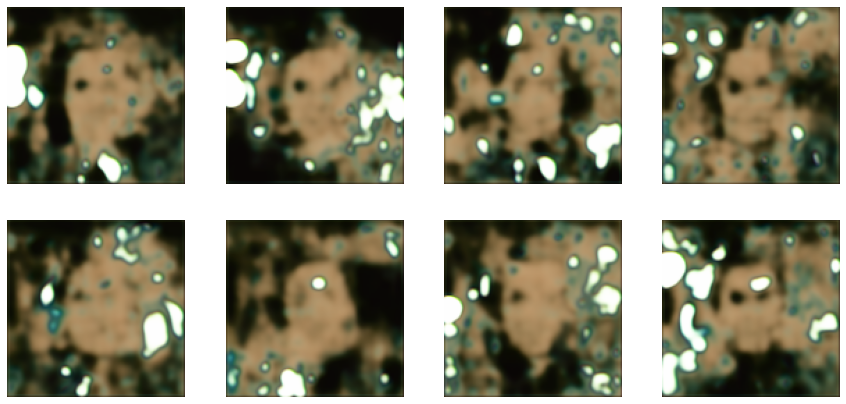

[step=400] Дискриминатор loss: 0.5678609609603882,               Генератор loss 1.4011859893798828


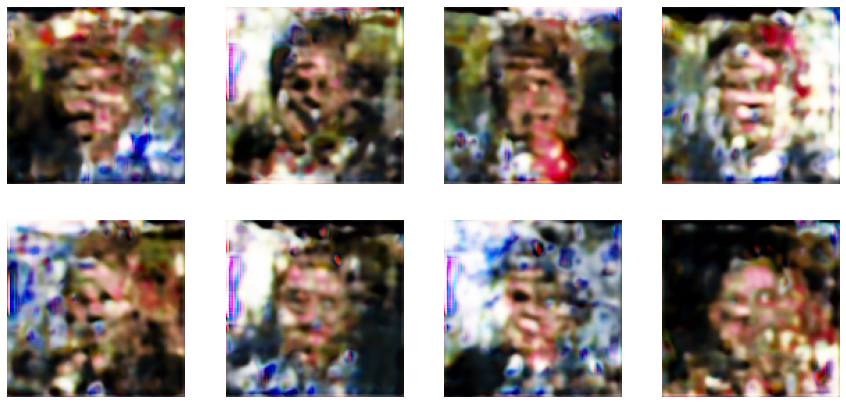

[step=800] Дискриминатор loss: 0.6432163715362549,               Генератор loss 0.9731214642524719


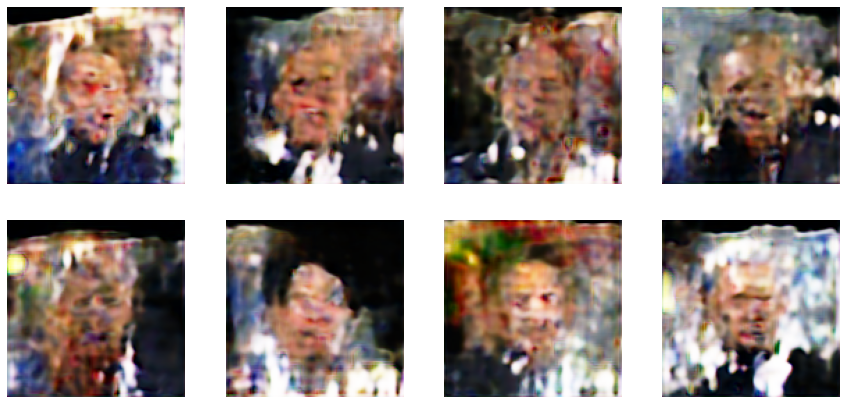

[step=1200] Дискриминатор loss: 0.7089958190917969,               Генератор loss 1.351909875869751


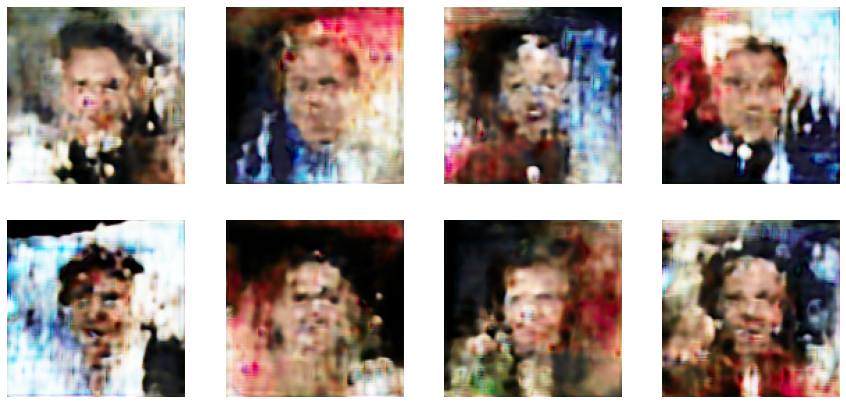

[step=1600] Дискриминатор loss: 0.6366603374481201,               Генератор loss 0.7297601103782654


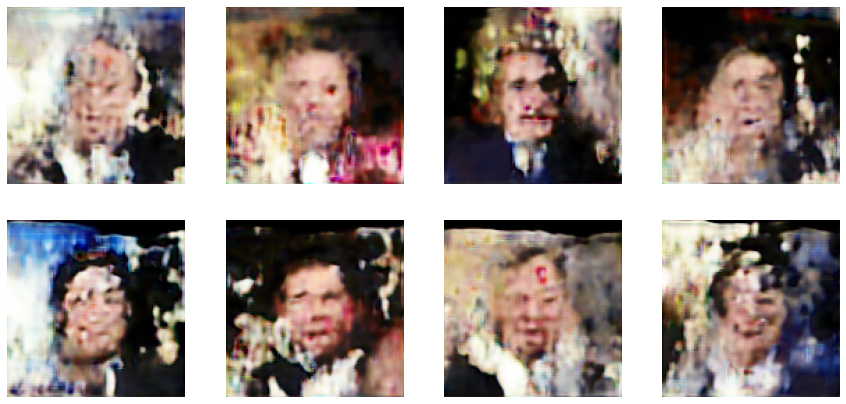

[step=2000] Дискриминатор loss: 0.674667477607727,               Генератор loss 0.2725599408149719


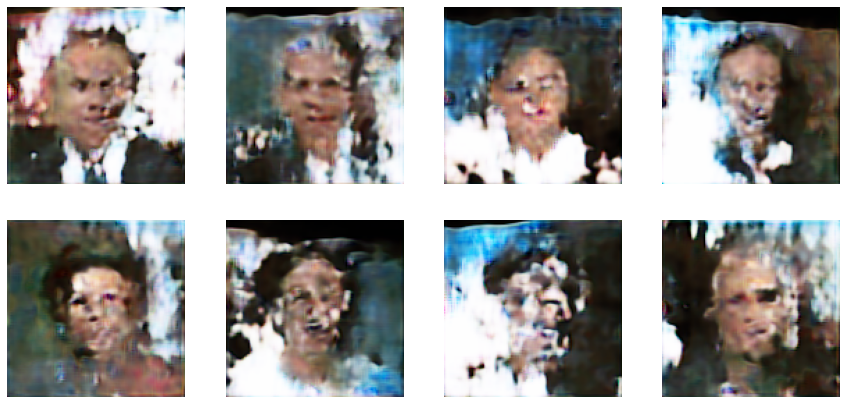

[step=2400] Дискриминатор loss: 0.6297821998596191,               Генератор loss 0.8286260366439819


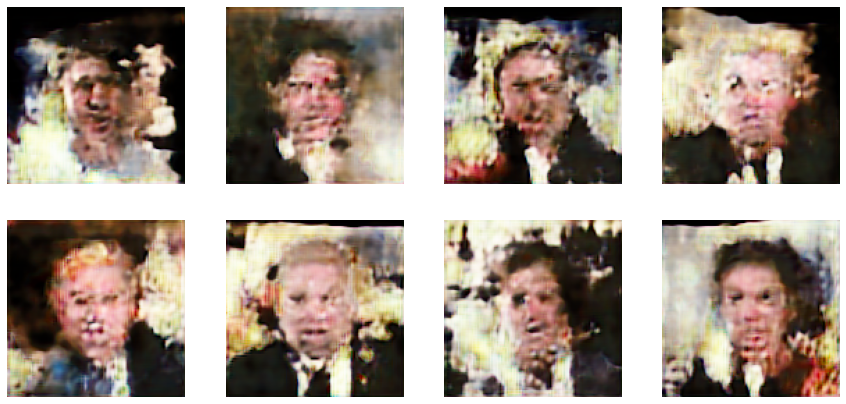

[step=2800] Дискриминатор loss: 0.6151804327964783,               Генератор loss 0.8613816499710083


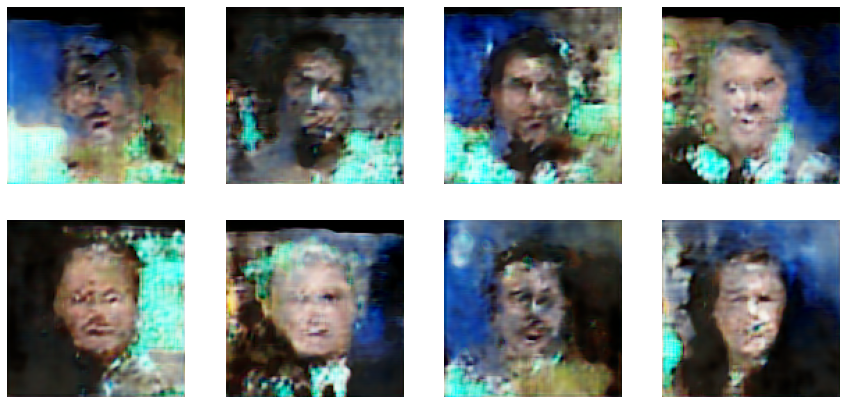

[step=3200] Дискриминатор loss: 0.4896473288536072,               Генератор loss 1.519709587097168


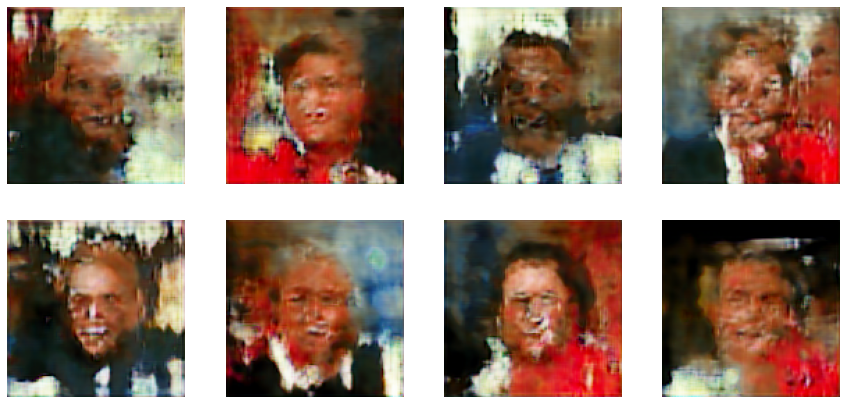

In [ ]:
for step, true_images in enumerate(train_ds):
    
    # Дискриминатор
    
    noise = np.random.normal(0, 1, (int(BATCH_SIZE/2), 100)).astype(np.float32)
    fake_images = generator.predict(noise)
    x_combined = np.concatenate((true_images, fake_images))
    y_combined = np.concatenate((np.ones((int(BATCH_SIZE/2), 1), np.float32),
                                np.zeros((int(BATCH_SIZE/2), 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined)
        d_loss_value = loss(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
        
    # Генератор
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, 100)).astype(np.float32)
    y_mislabeled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        logits = discriminator(generator(noise, training=True))
        g_loss_value = loss(y_mislabeled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    if step % 400 == 0:
        print(f'[{step=}] Дискриминатор loss: {d_loss_value.numpy()}, \
              Генератор loss {g_loss_value.numpy()}')
        noise = np.random.normal(0, 1, (8, 100)).astype(np.float32)
        fake_images = generator.predict(noise)
        
        plt.figure(figsize=(15, 15))
        for i, image in enumerate(fake_images):
            ax = plt.subplot(4, 4, i + 1)
            image = image * 255.
            ax.imshow(tf.cast(image, tf.uint8))
            plt.axis("off")
        plt.show()

In [ ]:
# Вобщем примерно такой же результата